# Importing modules and lexicon

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import random as random
import re
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.signal import savgol_filter
import scipy.spatial.distance as ssd
from scipy import stats
from pathlib import Path
from MY_FUNCTIONS import *
import seaborn as sns

In [2]:
lexicon = pd.read_csv('/home/inous/Documents/S2/INRIA/LEXIQUE/Lexique383/Lexique383.tsv', sep='\t')
lexicon = lexicon[['ortho', 'nbsyll']]
dictionnary = dict(zip(lexicon['ortho'], lexicon ['nbsyll']))

In [1]:
plots_path = "/home/inous/Documents/S2/INRIA/PLOTS2/"
#directory to stock all the plots

# Defining constants

In [4]:
remove_silences = 0  #silences between words of a same utterance
remove_shorter = 1  #utterances with only one word

In [5]:
my_red = (0.8,0,0)
my_blue= (0,0.4,0.8)
my_pink = (1,0.4,0.4)
my_green = (0,0.8,0.4)
my_purple = (0.6,0,0.3)
my_yellow = (0.89, 0.75, 0)
my_orange = (0.82, 0.55, 0)
my_turquoise = (0, 0.72, 0.58)
my_bordeaux = (0.51, 0.02, 0.08)

In [6]:
my_colors = [my_red, my_blue, my_pink, my_green, my_purple, my_yellow, my_orange, my_turquoise, my_bordeaux]

In [7]:
default_window = 9
default_poly = 3

# Importing data

In [8]:
WORDS = pd.read_csv("/home/inous/Documents/S2/INRIA/ALIGNED/word.csv")
WORDS = WORDS[ WORDS['Length']!=0] #to keep only non-zero intervals
filenames = WORDS['Filename'].unique()

# Separating AA and CA files 

In [9]:
WORDS_AA = []
WORDS_CA = []
for filename in filenames : 
    WORDS_file = WORDS[ WORDS['Filename']==filename][['Word','UtteranceName','Speaker', 'Length', 'Global_start', 'Filename', 'Global_end']]
    WORDS_file.reset_index(drop=True, inplace=True)
    WORDS_file=WORDS_file.sort_values('Speaker', ascending=True)
    if filename[0:2]=='AA':
        WORDS_AA.append(WORDS_file)
    else:
        WORDS_CA.append(WORDS_file)

# Creating a csv file for each conversation

## Computing the "syllables" column, and grouping words by utterances (keeping the first start and last end, summing syllables and length)

In [10]:
for i,WORDS in enumerate(WORDS_AA) :
        
    list_syll = []
    for word in WORDS['Word']:
        word=word.lower()
        if word in dictionnary:
            list_syll.append(dictionnary[word])
        else : 
            list_syll.append(estimate_syll(word))
            
    WORDS["syllables"] = list_syll
    WORDS=WORDS.sort_values('Global_start', ascending=True)
    WORDS_AA[i] = WORDS
        
    table = pd.pivot_table(WORDS, values = ['Length', 'Global_start', 'Global_end','syllables', 'Speaker', 'Filename', 'Word'], index = ['UtteranceName'], aggfunc = {'Length':np.sum, 'Global_start':min, 'syllables':np.sum, 'Speaker' : np.min, 'Filename':np.min, 'Word':'count', 'Global_end':max})
    table = table.sort_values('Global_start', ascending = True)
    if remove_silences:
        table['Speech rate'] = table['syllables']/table['Length']
    else:
        table['Speech rate'] = table['syllables']/(table['Global_end']-table['Global_start'])
    if remove_shorter:
        table = table[ table['Word']>1]
    WORDS_AA[i] = table
    table.to_csv('/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/AA/'+str(WORDS['Filename'][0])+'.csv')

In [11]:
for i,WORDS in enumerate(WORDS_CA) : 
        
    list_syll = []
    for word in WORDS['Word']:
        word=str(word)
        word = word.lower()
        if word in dictionnary:
            list_syll.append(dictionnary[word])
        else : 
            list_syll.append(estimate_syll(word))
    WORDS["syllables"] = list_syll
    WORDS_CA[i] = WORDS
    
    WORDS['Word'] = np.vectorize(str)(WORDS['Word'])
    WORDS.reset_index(inplace=True, drop=True)
    
    table = pd.pivot_table(WORDS, values = ['Word', 'UtteranceName', 'Global_start', 'Global_end', 'Length', "Filename", "syllables"], index = ['UtteranceName', "Speaker"], aggfunc = {"Global_end":max,"UtteranceName":np.unique,'Word':'count', 'Global_start':min, "Length":sum, "Speaker":np.unique, "Filename":np.unique, "syllables":sum})    
    table = table.sort_values('Global_start', ascending = True)
    
    if remove_silences :
        table['Speech rate'] = table['syllables']/table['Length']
    else : 
        table['Speech rate'] = table['syllables']/(table['Global_end']-table['Global_start'])
    if remove_shorter:
        table = table[ table['Word']>1]
    WORDS_CA[i] = table
    
    table.to_csv('/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/CA/'+str(WORDS['Filename'][0])+'.csv')

# Importing the new csv files

In [12]:
pathlist_AA = Path("/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/AA").glob('**/*.csv')
data_AA = []
filenames_AA = []

for path in pathlist_AA:
    if "BO" not in str(path):
        print(path)
        filenames_AA.append(str(path)[-12:-4])
        data_AA.append(pd.read_csv(path)) 

/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/AA/AA-LD-BF.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/AA/AA-MG-CH.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/AA/AA-MJ-CJ.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/AA/AA-JL-AZ.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/AA/AA-GD-DD.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/AA/AA-XA-EH.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/AA/AA-AN-DL.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/AA/AA-ML-MP.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/AA/AA-LA-AN.csv


In [13]:
pathlist_CA = Path("/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/CA").glob('**/*.csv')
data_CA = []
filenames_CA = []

for path in pathlist_CA:
    if "BO" not in str(path):
        print(path)
        filenames_CA.append(str(path)[-12:-4])
        data_CA.append(pd.read_csv(path)) 

/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/CA/CA-XA-LA.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/CA/CA-MB-LB.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/CA/CA-LJ-MJ.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/CA/CA-MD-GD.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/CA/CA-FB-MG.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/CA/CA-RL-ML.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/CA/CA-JL-JT.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/CA/CA-LD-GD.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ALIGNED/CA/CA-AN-ZN.csv


# Raw speech rate

In [14]:
fig1, axs1 = plt.subplots(3, 3, figsize=(20,17))

for i, data in enumerate(data_AA) :
    
    data_1 = data[ data['Speaker'] == "Adult1" ]
    data_2 = data[ data['Speaker'] == "Adult2" ]
    
    axs1[i//3,i%3].set_title(data['Filename'][0])
    axs1[i//3,i%3].set_xlabel('Time (sec)')
    axs1[i//3,i%3].set_ylabel('Speech rate')
    axs1[i//3,i%3].plot(data_1['Global_start'], data_1['Speech rate'], label="Adult1", color=my_blue)
    axs1[i//3,i%3].plot(data_2['Global_start'], data_2['Speech rate'], label="Adult2", color=my_red)
    
plt.tight_layout()
plt.close(fig1)
fig1.savefig(plots_path+"Raw AA speech rate")

In [15]:
fig2, axs2 = plt.subplots(3, 3, figsize=(20,17))

for i, data in enumerate(data_CA) :
    
    data_1 = data[ data['Speaker'] == "Parent" ]
    data_2 = data[ data['Speaker'] == "Child" ]
    
    axs2[i//3,i%3].set_title(data['Filename'][0])
    axs2[i//3,i%3].set_xlabel('Time (sec)')
    axs2[i//3,i%3].set_ylabel('Speech rate')
    axs2[i//3,i%3].plot(data_1['Global_start'], data_1['Speech rate'], label="Parent", color=my_blue)
    axs2[i//3,i%3].plot(data_2['Global_start'], data_2['Speech rate'], label="Child", color=my_red)
    
fig2.tight_layout()
plt.close(fig2)
fig2.savefig(plots_path+"Raw CA speech rate")

# Fourier Analysis

# Smoothed speech rate

## With a smoothing window of 10 utterances

In [16]:
fig3, axs3 = plt.subplots(3, 3, figsize=(20,17))

for i, table in enumerate(data_AA) :
    
    axs3[i//3,i%3].set_xlabel('time')
    axs3[i//3,i%3].set_ylabel('Speech rate')
    axs3[i//3,i%3].plot(table[table['Speaker']=='Adult1']['Global_start'], smooth_2(table[table['Speaker']=='Adult1']['Speech rate'], 29, 3), label='Adult1',color = my_red)
    axs3[i//3,i%3].plot( table[table['Speaker']=='Adult2']['Global_start'], smooth_2(table[table['Speaker']=='Adult2']['Speech rate'], 29, 3), label='Adult2', color=my_blue)
    axs3[i//3,i%3].set_title(str(table['Filename'][0]))
    axs3[i//3,i%3].legend()
    
    if "AA-LD-BF" in filenames_AA[i]:
        fig35 = plt.figure()
        plt.plot(table[table['Speaker']=='Adult1']['Global_start'], smooth_2(table[table['Speaker']=='Adult1']['Speech rate'], 29, 3), label='Adult1',color = my_red)
        plt.plot( table[table['Speaker']=='Adult2']['Global_start'], smooth_2(table[table['Speaker']=='Adult2']['Speech rate'], 29, 3), label='Adult2', color=my_blue)
        plt.xlabel("time (s)")
        plt.ylabel("Speech rate (syllables/s)")
        plt.close(fig35)
        fig35.savefig(examples_path+"Smoothed AA")
    
fig3.tight_layout()
plt.close(fig3)
fig3.savefig(test_path+"Smoothed AA speech rate")

In [18]:
fig4, axs4 = plt.subplots(3, 3, figsize=(20,15))

for i, table in enumerate(data_CA) :
    
    axs4[i//3,i%3].set_xlabel('time')
    axs4[i//3,i%3].set_ylabel('Speech rate')
    axs4[i//3,i%3].plot(table[table['Speaker']=='Parent']['Global_start'], smooth_2(table[table['Speaker']=='Parent']['Speech rate'],29, 3), label='Parent',color = my_red)
    axs4[i//3,i%3].plot( table[table['Speaker']=='Child']['Global_start'], smooth_2(table[table['Speaker']=='Child']['Speech rate'], 29, 3), label='Child', color=my_blue)
    axs4[i//3,i%3].set_title(str(table['Filename'][0]))
    axs4[i//3,i%3].legend()
    
    if "CA-LD-GD" in filenames_CA[i]:
        fig45 = plt.figure()
        plt.plot(table[table['Speaker']=='Parent']['Global_start'], smooth_2(table[table['Speaker']=='Parent']['Speech rate'], 29, 3), label='Parent',color = my_red)
        plt.plot( table[table['Speaker']=='Child']['Global_start'], smooth_2(table[table['Speaker']=='Child']['Speech rate'], 29, 3), label='Child', color=my_blue)
        plt.xlabel("time (s)")
        plt.ylabel("Speech rate (syllables/s)")
        plt.close(fig45)
        fig45.savefig(examples_path+"Smoothed CA")
    
fig4.tight_layout()
plt.close(fig4)
fig4.savefig(plots_path+"Smoothed CA speech rate")

# "Adapted" speech rate 

## To compute the correlation, the time series must have the same length

### Loading manual phases notes

In [20]:
path_AA = "/home/inous/Documents/S2/INRIA/DATA/MY_ANNOTATIONS_AA.txt"
text_AA = open(path_AA, 'r').read()

lines_AA = text_AA.split('\n')
Filenames_AA = []
Phases_AA = []
line = lines_AA[0]
file = []
for line in lines_AA:
    if line!='' and line!=' ':
        if "END" not in line :
            if "FILENAME" not in line:
                label, time_string = line.split('[')
                time_string = time_string.replace('[', '')
                time_string = time_string.replace(']', '')
                time_string = time_string.replace(' ', '')
                time = conversion_time(time_string)
                file.append([label, time])
            else:
                NOM, filename = line.split(' ')
        else:
            Filenames_AA.append(filename)
            Phases_AA.append(file)
            file=[]
phases_AA = pd.DataFrame(list(zip(Filenames_AA, Phases_AA)), columns = ['Filename', 'Phases'])

In [21]:
path_CA = "/home/inous/Documents/S2/INRIA/DATA/MY_ANNOTATIONS_CA.txt"
text_CA = open(path_CA, 'r').read()

lines_CA = text_CA.split('\n')
Filenames_CA = []
Phases_CA = []
line = lines_CA[0]
file = []
for line in lines_CA:
    if line!='' and line!=' ':
        if "END" not in line :
            if "FILENAME" not in line:
                label, time_string = line.split('[')
                time_string = time_string.replace('[', '')
                time_string = time_string.replace(']', '')
                time_string = time_string.replace(' ', '')
                time = conversion_time(time_string)
                file.append([label, time])
            else:
                NOM, filename = line.split(' ')
        else:
            Filenames_CA.append(filename)
            Phases_CA.append(file)
            file=[]
phases_CA = pd.DataFrame(list(zip(Filenames_CA, Phases_CA)), columns = ['Filename', 'Phases'])

### Adding phases, roles and smoothed columns, save as csv, and adapt the number of points

In [22]:
for i,filename in enumerate(filenames_AA):
    
    print(filename)
    
    data = data_AA[i]
    
    adapted_data = adapt_points_3(data,"Speaker", "Global_start", "Speech rate")
    
    liste_phases = list(phases_AA[phases_AA['Filename']==filename]['Phases'])[0]
    
    adapted_data['Phases'] = find_phases(adapted_data['Global_start'], liste_phases)
    adapted_data['Roles'] = find_roles(adapted_data['Global_start'], liste_phases)
    adapted_data["Word"] = data["Word"]
    
    adapted_data["smoothed"] = smoothed_column(adapted_data, default_window, 'AA')
    
    adapted_data.to_csv('/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/AA/'+str(filename)+'.csv')

AA-LD-BF
AA-MG-CH
AA-MJ-CJ
AA-JL-AZ
AA-GD-DD
AA-XA-EH
AA-AN-DL
AA-ML-MP
AA-LA-AN


In [23]:
for i,filename in enumerate(filenames_CA):
    
    print(filename)
    
    data = data_CA[i]
    
    adapted_data = adapt_points_3(data,"Speaker", "Global_start", "Speech rate")
    
    liste_phases = list(phases_CA[phases_CA['Filename']==filename]['Phases'])[0]
    
    adapted_data['Phases'] = find_phases(adapted_data['Global_start'], liste_phases)
    adapted_data['Roles'] = find_roles(adapted_data['Global_start'], liste_phases)
    adapted_data["Word"] = data["Word"]
    
    adapted_data["smoothed"] = smoothed_column(adapted_data, default_window, 'CA')
        
    adapted_data.to_csv('/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/CA/'+str(filename)+'.csv')

CA-XA-LA
CA-MB-LB
CA-LJ-MJ
CA-MD-GD
CA-FB-MG
CA-RL-ML
CA-JL-JT
CA-LD-GD
CA-AN-ZN


### Importing the new csv files

In [24]:
pathlist_AA = Path("/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/AA").glob('**/*.csv')
adapted_data_AA = []
adapted_filenames_AA = []

for path in pathlist_AA:
    if "BO" not in str(path):
        print(path)
        adapted_filenames_AA.append(str(path)[-12:-4])
        adapted_data_AA.append(pd.read_csv(path))

/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/AA/AA-LD-BF.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/AA/AA-MG-CH.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/AA/AA-MJ-CJ.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/AA/AA-JL-AZ.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/AA/AA-GD-DD.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/AA/AA-XA-EH.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/AA/AA-AN-DL.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/AA/AA-ML-MP.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/AA/AA-LA-AN.csv


In [25]:
pathlist_CA = Path("/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/CA").glob('**/*.csv')
adapted_data_CA = []
adapted_filenames_CA = []

for path in pathlist_CA:
    if "BO" not in str(path):
        print(path)
        adapted_filenames_CA.append(str(path)[-12:-4])
        adapted_data_CA.append(pd.read_csv(path))

/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/CA/CA-XA-LA.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/CA/CA-MB-LB.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/CA/CA-LJ-MJ.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/CA/CA-MD-GD.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/CA/CA-FB-MG.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/CA/CA-RL-ML.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/CA/CA-JL-JT.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/CA/CA-LD-GD.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_ADAPTED/CA/CA-AN-ZN.csv


### Plot of the adapted speech rate

In [26]:
fig5, axs5 = plt.subplots(9, 2, figsize=(15,20))

for i, adapted_data in enumerate(adapted_data_AA) :
    
    filename = adapted_filenames_AA[i]
    
    adapted_data_1 = adapted_data[ adapted_data['Speaker'] == "Adult1" ]
    adapted_data_2 = adapted_data[ adapted_data['Speaker'] == "Adult2" ]  

    
    adapted_data_1 = adapted_data[ adapted_data['Speaker'] == "Adult1" ]
    adapted_data_2 = adapted_data[ adapted_data['Speaker'] == "Adult2" ]
    
    axs5[i,0].set_title(filename+" speaker1")
    axs5[i,0].set_xlabel('Time (sec)')
    axs5[i,0].set_ylabel('Speech rate')
    axs5[i,0].plot(adapted_data_1['Global_start'], adapted_data_1['Speech rate'], label="Raw", color=my_blue)
    axs5[i,0].plot(adapted_data_1['Global_start'], adapted_data_1['Speech rate'],'o', label="Adapted", color=my_red)
    
    axs5[i,1].set_title(filename+" speaker2")
    axs5[i,1].set_xlabel('Time (sec)')
    axs5[i,1].set_ylabel('Adapted speech rate')
    axs5[i,1].plot(adapted_data_2['Global_start'], adapted_data_2['Speech rate'],label="Raw", color=my_blue)
    axs5[i,1].plot(adapted_data_2['Global_start'], adapted_data_2['Speech rate'], 'o',label="Adapted", color=my_red)
    
plt.tight_layout()
plt.close(fig5)
fig5.savefig(plots_path+"Adapted AA speech rate")

In [27]:
fig6, axs6 = plt.subplots(9, 2, figsize=(15,20))

for i, adapted_data in enumerate(adapted_data_CA) :
    
    filename = adapted_filenames_CA[i]
    
    adapted_data_1 = adapted_data[ adapted_data['Speaker'] == "Parent" ]
    adapted_data_2 = adapted_data[ adapted_data['Speaker'] == "Child" ]  

    
    adapted_data_1 = adapted_data[ adapted_data['Speaker'] == "Parent" ]
    adapted_data_2 = adapted_data[ adapted_data['Speaker'] == "Child" ]
    
    axs6[i,0].set_title(filename+" speaker1")
    axs6[i,0].set_xlabel('Time (sec)')
    axs6[i,0].set_ylabel('Speech rate')
    axs6[i,0].plot(adapted_data_1['Global_start'], adapted_data_1['Speech rate'], label="Raw", color=my_blue)
    axs6[i,0].plot(adapted_data_1['Global_start'], adapted_data_1['Speech rate'],'o', label="Adapted", color=my_red)
    
    axs6[i,1].set_title(filename+" speaker2")
    axs6[i,1].set_xlabel('Time (sec)')
    axs6[i,1].set_ylabel('Adapted speech rate')
    axs6[i,1].plot(adapted_data_2['Global_start'], adapted_data_2['Speech rate'],label="Raw", color=my_blue)
    axs6[i,1].plot(adapted_data_2['Global_start'], adapted_data_2['Speech rate'], 'o',label="Adapted", color=my_red)
    
plt.tight_layout()
plt.close(fig6)
fig6.savefig(plots_path+"Adapted CA speech rate")

# Global correlation

In [28]:
correlation_list_AA = []
p_values_AA = []

for data in adapted_data_AA :
    
    speaker1, speaker2 = np.unique(data['Speaker'])
    
    data_1 = data[data['Speaker']==speaker1]['Speech rate']
    data_2 = data[data['Speaker']==speaker2]['Speech rate']
    
    correlation, p_value = stats.pearsonr(np.array(data_1), np.array(data_2))
    correlation_list_AA.append(correlation)
    p_values_AA.append(p_value)

In [29]:
fig7 = plt.figure()

for i, filename in enumerate(filenames_AA):
    
    corr = correlation_list_AA[i]
    p_value = p_values_AA[i]
    plt.plot(["correlation"], [corr], 'o', label=filename, color=my_colors[i])
    plt.plot(["p_value"], [p_value], 'o',color=my_colors[i])
    
plt.legend()
plt.close(fig7)
fig7.savefig(plots_path+"Global AA correlation")

In [30]:
correlation_list_CA = []
p_values_CA = []

for data in adapted_data_CA :
    
    speaker1, speaker2 = np.unique(data['Speaker'])
    
    data_1 = data[data['Speaker']==speaker1]['Speech rate']
    data_2 = data[data['Speaker']==speaker2]['Speech rate']
    
    correlation, p_value = stats.pearsonr(np.array(data_1), np.array(data_2))
    correlation_list_CA.append(correlation)
    p_values_CA.append(p_value)

In [31]:
fig8 = plt.figure()

for i, filename in enumerate(filenames_CA):
    
    corr = correlation_list_CA[i]
    p_value = p_values_CA[i]
    plt.plot(["correlation"], [corr], 'o',color=my_colors[i], label=filename)
    plt.plot(["p_value"], [p_value], 'o', color=my_colors[i])
    
plt.legend()
plt.close(fig8)
fig8.savefig(plots_path+"Global CA correlation")

## Global correlation with default window smoothing

In [46]:
correlation_list_AA = []
p_values_AA = []

for data in adapted_data_AA :
    
    speaker1, speaker2 = np.unique(data['Speaker'])

    data_1 = data[data['Speaker']==speaker1]
    data_2 = data[data['Speaker']==speaker2]
    
    correlation, p_value = stats.pearsonr(smooth_2(data_1['Speech rate'], default_window, default_poly), smooth_2(data_2['Speech rate'], default_window, default_poly))

    correlation_list_AA.append(correlation)
    p_values_AA.append(p_value)

In [47]:
fig9 = plt.figure()

for i, filename in enumerate(filenames_AA):
    
    corr = correlation_list_AA[i]
    p_value = p_values_AA[i]
    plt.plot(["correlation"], [corr], 'o', label=filename, color=my_colors[i])
    plt.plot(["p_value"], [p_value], 'o',color=my_colors[i])
    
plt.legend()
plt.close(fig9)
fig9.savefig(plots_path+"Global AA smoothed correlation")

In [48]:
correlation_list_CA = []
p_values_CA = []

for data in adapted_data_CA :
    
    speaker1, speaker2 = np.unique(data['Speaker'])

    data_1 = data[data['Speaker']==speaker1]
    data_2 = data[data['Speaker']==speaker2]
    
    correlation, p_value = stats.pearsonr(smooth_2(data_1['Speech rate'], default_window, default_poly), smooth_2(data_2['Speech rate'], default_window, default_poly))

    correlation_list_CA.append(correlation)
    p_values_CA.append(p_value)

In [49]:
fig10 = plt.figure()

for i, filename in enumerate(filenames_CA):
    
    corr = correlation_list_CA[i]
    p_value = p_values_CA[i]
    plt.plot(["correlation"], [corr], 'o', label=filename, color=my_colors[i])
    plt.plot(["p_value"], [p_value], 'o',color=my_colors[i])
    
plt.legend()
plt.close(fig10)
fig10.savefig(plots_path+"Global CA smoothed correlation")

# Influence of the smoothing window on global correlation

In [33]:
windows = np.arange(5, 25, 2)

In [34]:
correlations_AA = []
p_values_AA = []

for i, data in enumerate(adapted_data_AA):
    
    correlation_file = []
    p_value_file = []
    
    filename = adapted_filenames_AA[i]
    
    data1  = data[data['Speaker']=='Adult1']
    data2  = data[data['Speaker']=='Adult2']
    
    for window in windows :
        
        corr, p_value = stats.pearsonr(smooth_2(data1['Speech rate'], window, default_poly), smooth_2(data2['Speech rate'], window, default_poly))
        correlation_file.append(corr)
        p_value_file.append(p_value)
        
    correlations_AA.append(correlation_file)
    p_values_AA.append(p_value_file)

In [35]:
fig11 = plt.figure()

for i, filename in enumerate(filenames_AA):

    plt.plot(windows, correlations_AA[i], label=filename, color=my_colors[i])
    #plt.plot(windows, p_values_AA[i], '--',color=my_colors[i])

plt.xlabel("smoothing window")
plt.ylabel("correlation")
plt.legend()
plt.close(fig11)
fig11.savefig(plots_path+"Window influence on correlation AA")

In [36]:
correlations_CA = []
p_values_CA = []

for i, data in enumerate(adapted_data_CA):
    
    correlation_file = []
    p_values_file = []
    
    filename = adapted_filenames_CA[i]
    
    data1  = data[data['Speaker']=='Parent']
    data2  = data[data['Speaker']=='Child']
    
    for window in windows :
        
        corr, p_value = stats.pearsonr(smooth_2(data1['Speech rate'], window, default_poly), smooth_2(data2['Speech rate'], window, default_poly))
        correlation_file.append(corr)
        p_values_file.append(p_value)
        
    correlations_CA.append(correlation_file)
    p_values_CA.append(p_values_file)

In [37]:
fig12 = plt.figure()

for i, filename in enumerate(filenames_CA):

    plt.plot(windows, correlations_CA[i], label=filename, color=my_colors[i])
    #plt.plot(windows, p_values_CA[i], "--", color=my_colors[i] )
    
plt.xlabel("smoothing window")
plt.ylabel("correlation")
plt.legend(loc=4)
plt.close(fig12)
fig12.savefig(plots_path+"Window influence on correlation CA")

# Phases

## The conversation contains three phases : pregame conversation (explanation of the rules, often a monologue), the guessing game, and postgame conversation.

### Computing the correlation of each phase 

In [38]:
Phases = ['PREGAME', 'GAME', 'POSTGAME']

In [39]:
list_corr_files_AA = []
nb_points_files_AA = []
p_values_files_AA = []

for i, filename in enumerate(filenames_AA):

    print(filename)
    
    list_corr = []
        
    df = pd.read_csv('/home/inous/Documents/S2/INRIA/OUTPUT/CSV_PHASES/AA/'+str(filename)+'.csv')
    
    corr_phases, nb_points, p_values = compute_corr_phases(df, Phases, "Phases", "smoothed", "Speaker", "Global_start")

    p_values_files_AA.append(p_values)        
    list_corr_files_AA.append(corr_phases)
    nb_points_files_AA.append(nb_points)


mean_corr = [my_mean([list_corr_files_AA[j][i] for i in range(len(list_corr_files_AA[j]))]) for j in range(len(list_corr_files_AA))]

AA-LD-BF
AA-MG-CH
AA-MJ-CJ
AA-JL-AZ
AA-GD-DD
AA-XA-EH
AA-AN-DL
AA-ML-MP
AA-LA-AN


In [40]:
list_corr_files_CA = []
nb_points_files_CA = []
p_values_files_CA = []

for i, filename in enumerate(filenames_CA):
    list_corr = []
        
    file = data_CA[i]

    df = pd.read_csv('/home/inous/Documents/S2/INRIA/OUTPUT/CSV_PHASES/CA/'+str(filename)+'.csv')
    
    corr_phases, nb_points, p_values = compute_corr_phases(df, Phases, "Phases", "smoothed", "Speaker", "Global_start")

    p_values_files_CA.append(p_values)
    list_corr_files_CA.append(corr_phases)
    nb_points_files_CA.append(nb_points)

mean_corr = [my_mean([list_corr_files_CA[j][i] for i in range(len(list_corr_files_CA[j]))]) for j in range(len(list_corr_files_CA))]

### Plotting phases on the speech rate

In [46]:
fig13, axs13 = plt.subplots(9, 1, figsize=(15,20))

for i, table in enumerate(data_AA) :
    
    filename = filenames_AA[i]
    
    axs13[i].set_xlabel('time')
    axs13[i].set_ylabel('Speech rate')
    axs13[i].plot(table[table['Speaker']=='Adult1']['Global_start'], smooth_2(table[table['Speaker']=='Adult1']['Speech rate'], default_window, default_poly), label='Adult1',color = my_red)
    axs13[i].plot( table[table['Speaker']=='Adult2']['Global_start'], smooth_2(table[table['Speaker']=='Adult2']['Speech rate'], default_window, default_poly), label='Adult2', color=my_blue)
    axs13[i].set_title(str(table['Filename'][0]))
    axs13[i].legend()
    
    liste_phases = list(phases_AA[phases_AA['Filename']==filename]['Phases'])[0]
    
    for couple in liste_phases:
        
        label, time = couple

        if "1" in label:
            axs13[i].axvline(x=time, color='r')
        elif "2" in label:
            axs13[i].axvline(x=time, color='b')
        else :
            axs13[i].axvline(x=time, color='orange')
            
    if "AA-MG-CH" in filename:
        fig135 = plt.figure(figsize=(20,5))
        plt.plot(table[table['Speaker']=='Adult1']['Global_start'], smooth_2(table[table['Speaker']=='Adult1']['Speech rate'], default_window, default_poly), label='Adult1',color = my_red)
        plt.plot( table[table['Speaker']=='Adult2']['Global_start'], smooth_2(table[table['Speaker']=='Adult2']['Speech rate'], default_window, default_poly), label='Adult2', color=my_blue)
        
        for couple in liste_phases:
        
            label, time = couple

            if "1" in label:
                plt.axvline(x=time, color='r')
            elif "2" in label:
                plt.axvline(x=time, color='b')
            else :
                plt.axvline(x=time, color='orange')
        
        plt.close(fig135)
        fig135.savefig(examples_path + "Phases_SR_AA")

plt.tight_layout()
plt.close(fig13)
fig13.savefig(plots_path+"Phases and smoothed speech rate AA")

In [46]:
fig14, axs14 = plt.subplots(9, 1, figsize=(15,20))

for i, table in enumerate(data_CA) :
    
    filename = filenames_CA[i]
    
    axs14[i].set_xlabel('time')
    axs14[i].set_ylabel('Speech rate')
    axs14[i].plot(table[table['Speaker']=='Parent']['Global_start'], smooth_2(table[table['Speaker']=='Parent']['Speech rate'], default_window, default_poly), label='Parent',color = my_red)
    axs14[i].plot( table[table['Speaker']=='Child']['Global_start'], smooth_2(table[table['Speaker']=='Child']['Speech rate'], default_window, default_poly), label='Child', color=my_blue)
    axs14[i].set_title(str(table['Filename'][0]))
    axs14[i].legend()
    
    liste_phases = list(phases_CA[phases_CA['Filename']==filename]['Phases'])[0]
    
    for couple in liste_phases:
        
        label, time = couple

        if "1" in label:
            axs14[i].axvline(x=time, color='r')
        elif "2" in label:
            axs14[i].axvline(x=time, color='b')
        else :
            axs14[i].axvline(x=time, color='orange')

plt.tight_layout()
plt.close(fig14)
fig14.savefig(plots_path+"Phases and smoothed speech rate CA")

### Plotting correlation of each phase

In [47]:
fig15, axs15 = plt.subplots(3,1, figsize=(10,10))
ax1, ax2, ax3 = axs15

for i, list_corr in enumerate(list_corr_files_AA):
    
    ax1.plot(Phases, list_corr, 'o',label=str(filenames_AA[i]))
    
    ax2.plot(Phases, nb_points_files_AA[i],'o', label=str(filenames_AA[i]))
    
    ax3.plot(Phases, p_values_files_AA[i],'o', label=str(filenames_AA[i]))
    
ax1.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

ax1.set_ylabel("correlation")
ax2.set_ylabel("number of utterances points")
ax3.set_ylabel("p_value")

ax1.legend(loc=(0.2, 0.05))
ax2.legend(loc=(0.2, 0.05))
ax3.legend(loc=(0.2, 0.05))

plt.close(fig15)
fig15.savefig(plots_path+"Correlation by phase AA")

In [48]:
fig16, axs16 = plt.subplots(3,1, figsize=(10,10))
ax1, ax2, ax3 = axs16

for i, list_corr in enumerate(list_corr_files_CA):
    
    ax1.plot(Phases, list_corr, 'o',label=str(filenames_CA[i]))
    
    ax2.plot(Phases, nb_points_files_CA[i], 'o',label=str(filenames_CA[i]))
    
    ax3.plot(Phases, p_values_files_CA[i],'o', label=str(filenames_CA[i]))
    
ax1.yaxis.set_ticks_position('both')
ax2.yaxis.set_ticks_position('both')

ax1.set_ylabel("correlation")
ax2.set_ylabel("number of utterances points")
ax3.set_ylabel("p_value")

ax1.legend(loc=(0.2, 0.05))
ax2.legend(loc=(0.2, 0.05))
ax3.legend(loc=(0.2, 0.05))

plt.close(fig16)
fig16.savefig(plots_path+"Correlation by phase CA")

# Correlation by game role

## Each speaker is alternatively asking or answering the questions

In [49]:
Roles_AA, Correlations_AA, p_values_AA = [],[], []

for i, data in enumerate(adapted_data_AA):

    filename = filenames_AA[i]
    
    roles, correlations, p_values = compute_corr_roles(data, "Roles", "Speech rate", "Speaker", "Global_start")
    
    Roles_AA.append(roles)
    Correlations_AA.append(correlations)
    p_values_AA.append(p_values)

In [50]:
fig17, axs17 = plt.subplots(3,3, figsize=(10,10))


for i in range(len(Roles_AA)):

    axs17[i//3,i%3].plot(Roles_AA[i], Correlations_AA[i], 'o')
    axs17[i//3,i%3].set_title(filenames_AA[i])

plt.close(fig17)
fig17.tight_layout()
fig17.savefig(plots_path+"Correlation by role AA")

In [51]:
Roles_CA, Correlations_CA, p_values_CA = [],[], []

for i, data in enumerate(adapted_data_CA):

    filename = filenames_CA[i]
    
    roles, correlations, p_values = compute_corr_roles(data, "Roles", "Speech rate", "Speaker", "Global_start")
    
    Roles_CA.append(roles)
    Correlations_CA.append(correlations)
    p_values_CA.append(p_values)

In [52]:
fig18, axs18 = plt.subplots(3,3, figsize=(10,10))


for i in range(len(Roles_CA)):

    axs18[i//3,i%3].plot(Roles_CA[i], Correlations_CA[i], 'o')
    axs18[i//3,i%3].set_title(filenames_CA[i])
    
plt.close(fig18)
fig18.tight_layout()
fig18.savefig(plots_path+"Correlation by role CA")

# Number of words

## Adult/adult vs Adult/child

In [53]:
nb_words_adult_1 = []
nb_words_adult_2 = []


for i, data in enumerate(data_AA) :
    
    data_1 = data[data["Speaker"]=="Adult1"]
    data_2 = data[data["Speaker"]=="Adult2"]
    
    mean_1 = np.mean(data_1["Word"])
    mean_2 = np.mean(data_2["Word"])
    
    nb_words_adult_1.append(mean_1)
    nb_words_adult_2.append(mean_2)

In [54]:
nb_words_adult = []
nb_words_child = []


for i, data in enumerate(data_CA) :
    
    
    data_adult = data[data["Speaker"]=="Parent"]
    data_child = data[data["Speaker"]=="Child"]
        
    mean_adult = np.mean(data_adult["Word"])
    mean_child = np.mean(data_child["Word"])
    
    nb_words_adult.append(mean_adult)
    nb_words_child.append(mean_child)

In [55]:
fig19, axs19 = plt.subplots(1,2, figsize=(10,5))

for i, filename in enumerate(filenames_AA):
    
    axs19[0].plot(["Adult 1", "Adult 2"], [nb_words_adult_1[i], nb_words_adult_2[i]], 'o', label=filename)
    
axs19[0].axhline(y=np.mean(nb_words_adult_1), label="Adult1", color='r')
axs19[0].axhline(y=np.mean(nb_words_adult_2), label="Adult2", color='b')

for j, filename in enumerate(filenames_CA):
    
    axs19[1].plot(["Parent", "Child"], [nb_words_adult[j], nb_words_child[j]], 'o', label=filename)
    
axs19[1].axhline(y=np.mean(nb_words_adult), label="Adult", color='r')
axs19[1].axhline(y=np.mean(nb_words_child), label="Child", color='b')
    
axs19[0].set_title("Mean number of words for both adults")
axs19[1].set_title("Mean number of words for adult and child")

axs19[0].legend(loc=9,fontsize=8)
axs19[1].legend(loc=9,fontsize=8)

plt.close(fig19)
fig19.savefig(plots_path+"Mean number of words AA VS CA")

## Coding roles in a more convenient way (ask or answer)

In [56]:
for i, data in enumerate(adapted_data_AA):
    
    roles_file = []
    
    for j in range(len(data)):
        
        if (data["Speaker"][j]=="Adult1" and data["Roles"][j]=="SPEAKER1 ") or (data["Speaker"][j]=="Adult2" and data["Roles"][j]=="SPEAKER2 "):
            roles_file.append("ans")
            
        else:
            roles_file.append("ask")
            
    data["New_role"]=roles_file
    adapted_data_AA[i] = data

In [57]:
for i, data in enumerate(adapted_data_CA):
    
    roles_file = []
    
    for j in range(len(data)):
        
        if (data["Speaker"][j]=="Parent" and data["Roles"][j]=="SPEAKER1 ") or (data["Speaker"][j]=="Child" and data["Roles"][j]=="SPEAKER2 "):
            roles_file.append("ans")
            
        else:
            roles_file.append("ask")
            
    data["New_role"]=roles_file
    adapted_data_CA[i] = data

## Number of words by role

In [58]:
adult_1_ans = []
adult_1_ask = []

adult_2_ans = []
adult_2_ask = []

for i, data in enumerate(adapted_data_AA):
    
    filename = adapted_filenames_AA[i]
    
    data_1 = data[data["Speaker"]=="Adult1"]
    
    data_1_ans = data_1[data_1["New_role"]=="ans"]
    data_1_ask = data_1[data_1["New_role"]=="ask"]
    
    mean_1_ans = np.mean(data_1_ans["Word"])
    mean_1_ask = np.mean(data_1_ask["Word"])
    
    adult_1_ans.append(mean_1_ans)
    adult_1_ask.append(mean_1_ask)
    
    data_2 = data[data["Speaker"]=="Adult2"]
    data_2_ans = data_2[data_2["New_role"]=="ans"]
    data_2_ask = data_2[data_2["New_role"]=="ask"]
    
    mean_2_ans = np.mean(data_2_ans["Word"])
    mean_2_ask = np.mean(data_2_ask["Word"])
    
    adult_2_ans.append(mean_2_ans)
    adult_2_ask.append(mean_2_ask)

In [59]:
adult_ans = []
adult_ask = []

child_ans = []
child_ask = []

for i, data in enumerate(adapted_data_CA):
    
    filename = adapted_filenames_CA[i]
    
    data_1 = data[data["Speaker"]=="Parent"]
    data_1_ans = data_1[data_1["New_role"]=="ans"]
    data_1_ask = data_1[data_1["New_role"]=="ask"]
    
    mean_1_ans = np.mean(data_1_ans["Word"])
    mean_1_ask = np.mean(data_1_ask["Word"])
    
    adult_ans.append(mean_1_ans)
    adult_ask.append(mean_1_ask)
    
    data_2 = data[data["Speaker"]=="Child"]
    data_2_ans = data_2[data_2["New_role"]=="ans"]
    data_2_ask = data_2[data_2["New_role"]=="ask"]
    
    mean_2_ans = np.mean(data_2_ans["Word"])
    mean_2_ask = np.mean(data_2_ask["Word"])
    
    child_ans.append(mean_2_ans)
    child_ask.append(mean_2_ask)

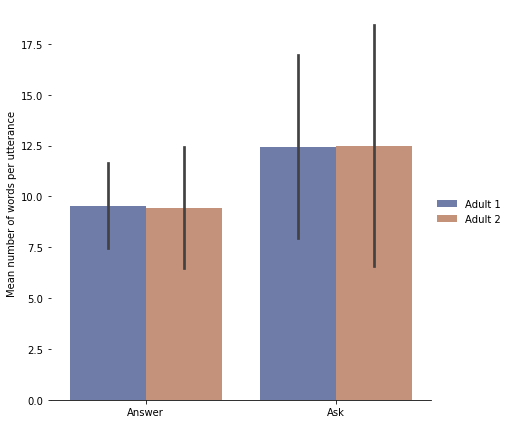

In [60]:
speaker = ["Adult 1" for i in range(len(adult_1_ans)+len(adult_1_ask))]+["Adult 2" for i in range(len(adult_2_ans)+len(adult_2_ask))]
role = ["Answer" for i in range(len(adult_1_ans))] + ["Ask" for i in range(len(adult_1_ask))] + ["Answer" for i in range(len(adult_2_ans))]+ ["Ask" for i in range(len(adult_2_ask))]
words = adult_1_ans + adult_1_ask + adult_2_ans + adult_2_ask
dico_AA = {"Speaker":speaker, "Role":role,"Words":words}
df_AA = pd.DataFrame(dico_AA)

fig20 = sns.catplot(data=df_AA, kind="bar", x="Role", y="Words", hue="Speaker", ci="sd", palette="dark", alpha=.6, height=6)
fig20.despine(left=True)
fig20.set_axis_labels("", "Mean number of words per utterance")
fig20.legend.set_title("")

fig20.savefig(plots_path+"Mean nb of words by role AA")

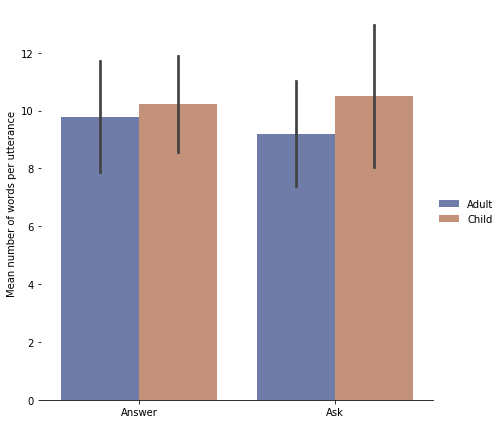

In [61]:
speaker = ["Adult" for i in range(len(adult_ans)+len(adult_ask))]+["Child" for i in range(len(child_ans)+len(child_ask))]
role = ["Answer" for i in range(len(adult_ans))] + ["Ask" for i in range(len(adult_ask))] + ["Answer" for i in range(len(child_ans))]+ ["Ask" for i in range(len(child_ask))]
words = adult_ans + adult_ask + child_ans + child_ask
dico_CA = {"Speaker":speaker, "Role":role,"Words":words}
df_CA = pd.DataFrame(dico_CA)

fig21 = sns.catplot(data=df_CA, kind="bar", x="Role", y="Words",hue="Speaker", ci="sd", palette="dark", alpha=.6, height=6)
fig21.despine(left=True)
fig21.set_axis_labels("", "Mean number of words per utterance")
fig21.legend.set_title("")

fig21.savefig(plots_path+"Mean nb of words by role CA")

# Mean speech rate by role

In [62]:
adult_1_ans_SR = []
adult_1_ask_SR = []

adult_2_ans_SR = []
adult_2_ask_SR = []

for i, data in enumerate(adapted_data_AA):
    
    filename = adapted_filenames_AA[i]
    
    data_1 = data[data["Speaker"]=="Adult1"]
    
    data_1_ans = data_1[data_1["New_role"]=="ans"]
    data_1_ask = data_1[data_1["New_role"]=="ask"]
    
    mean_1_ans = np.mean(data_1_ans["Speech rate"])
    mean_1_ask = np.mean(data_1_ask["Speech rate"])
    
    adult_1_ans_SR.append(mean_1_ans)
    adult_1_ask_SR.append(mean_1_ask)
    
    data_2 = data[data["Speaker"]=="Adult2"]
    data_2_ans = data_2[data_2["New_role"]=="ans"]
    data_2_ask = data_2[data_2["New_role"]=="ask"]
    
    mean_2_ans = np.mean(data_2_ans["Speech rate"])
    mean_2_ask = np.mean(data_2_ask["Speech rate"])
    
    adult_2_ans_SR.append(mean_2_ans)
    adult_2_ask_SR.append(mean_2_ask)

In [63]:
adult_ans_SR = []
adult_ask_SR = []

child_ans_SR = []
child_ask_SR = []

for i, data in enumerate(adapted_data_CA):
    
    filename = adapted_filenames_CA[i]
    
    data_1 = data[data["Speaker"]=="Parent"]
    data_1_ans = data_1[data_1["New_role"]=="ans"]
    data_1_ask = data_1[data_1["New_role"]=="ask"]
    
    mean_1_ans = np.mean(data_1_ans["Speech rate"])
    mean_1_ask = np.mean(data_1_ask["Speech rate"])
    
    adult_ans_SR.append(mean_1_ans)
    adult_ask_SR.append(mean_1_ask)
    
    data_2 = data[data["Speaker"]=="Child"]
    data_2_ans = data_2[data_2["New_role"]=="ans"]
    data_2_ask = data_2[data_2["New_role"]=="ask"]
    
    mean_2_ans = np.mean(data_2_ans["Speech rate"])
    mean_2_ask = np.mean(data_2_ask["Speech rate"])
    
    child_ans_SR.append(mean_2_ans)
    child_ask_SR.append(mean_2_ask)

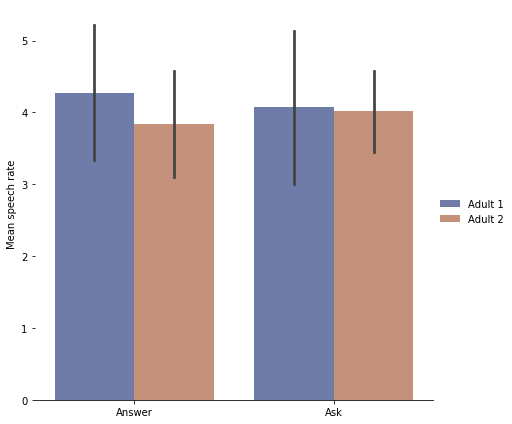

In [64]:
speaker = ["Adult 1" for i in range(len(adult_1_ans_SR)+len(adult_1_ask_SR))]+["Adult 2" for i in range(len(adult_2_ans_SR)+len(adult_2_ask_SR))]
role = ["Answer" for i in range(len(adult_1_ans_SR))] + ["Ask" for i in range(len(adult_1_ask_SR))] + ["Answer" for i in range(len(adult_2_ans_SR))]+ ["Ask" for i in range(len(adult_2_ask_SR))]
SR = adult_1_ans_SR + adult_1_ask_SR + adult_2_ans_SR + adult_2_ask_SR
dico_AA = {"Speaker":speaker, "Role":role,"SR":SR}
df_AA = pd.DataFrame(dico_AA)

fig22 = sns.catplot(data=df_AA, kind="bar", x="Role", y="SR", hue="Speaker", ci="sd", palette="dark", alpha=.6, height=6)
fig22.despine(left=True)
fig22.set_axis_labels("", "Mean speech rate")
fig22.legend.set_title("")

fig22.savefig(plots_path+"Mean SR by role AA")

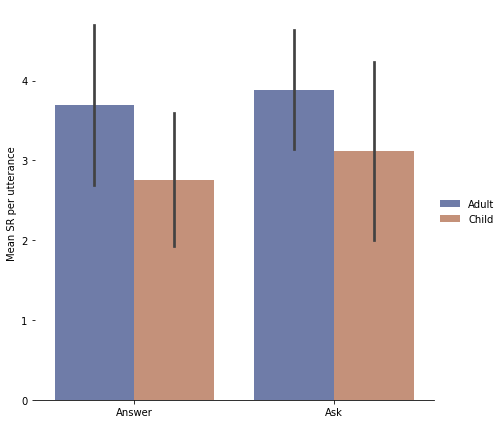

In [65]:
speaker = ["Adult" for i in range(len(adult_ans_SR)+len(adult_ask_SR))]+["Child" for i in range(len(child_ans_SR)+len(child_ask_SR))]
role = ["Answer" for i in range(len(adult_ans_SR))] + ["Ask" for i in range(len(adult_ask_SR))] + ["Answer" for i in range(len(child_ans_SR))]+ ["Ask" for i in range(len(child_ask_SR))]
SR = adult_ans_SR + adult_ask_SR + child_ans_SR + child_ask_SR
dico_CA = {"Speaker":speaker, "Role":role,"SR":SR}
df_CA = pd.DataFrame(dico_CA)

fig23 = sns.catplot(data=df_CA, kind="bar", x="Role", y="SR",hue="Speaker", ci="sd", palette="dark", alpha=.6, height=6)
fig23.despine(left=True)
fig23.set_axis_labels("", "Mean SR per utterance")
fig23.legend.set_title("")

fig23.savefig(plots_path+"Mean SR by role CA")